# Pickle de los datos

In [ ]:
# Guardamos los datos de las vectorizaciones con Pickle
import pickle
pickle_file = file('vectorizaciones.plk', 'w')
pickle.dump(vectorizaciones, pickle_file)

In [ ]:
# Cargamos los datos guardados de las vectorizaciones
import pickle
pickle_file = file('vectorizaciones.plk')
vectorizaciones = pickle.load(pickle_file)

# Carga de los datos

In [1]:
train_file = 'verbalAutopsy_train.csv'
test_file = 'verbalAutopsy_test.csv'

extended_file = 'PHMRC_VAI_redacted_free_text_1.xlsx'

model_doc2vec = 'my_doc2vec_n100.model'

In [2]:
def mapeo_de_labels(datos_df, columna):
    # PRE: docframe con todos los datos. "columna" es la entrada que contiene los labels reales
    # POST: devuelve el mismo docframe añadiendo la columna "Clases" en las cuales se mapean los valores de la
    #       columna que se recibe como parámetro en funcion del diccionario "mapeo"  
    
    mapeo = {
        'Diarrhea/Dysentery': 'Certain infectious and Parasitic Diseases',
        'Other infectious diseases': 'Certain infectious and Parasitic Diseases',
        'AIDS': 'Certain infectious and Parasitic Diseases',
        'Sepsis': 'Certain infectious and Parasitic Diseases',
        'Meningitis': 'Certain infectious and Parasitic Diseases',
        'Meningitis/Sepsis': 'Certain infectious and Parasitic Diseases',
        'Malaria': 'Certain infectious and Parasitic Diseases',
        'Encephalitis': 'Certain infectious and Parasitic Diseases',
        'Measles': 'Certain infectious and Parasitic Diseases',
        'Hemorrhagic Fever': 'Certain infectious and Parasitic Diseases',
        'TB': 'Certain infectious and Parasitic Diseases',
        'Leukemia/Lymphomas': 'Neoplasms',
        'Colorectal Cancer': 'Neoplasms',
        'Lung Cancer': 'Neoplasms',
        'Cervical Cancer': 'Neoplasms',
        'Breast Cancer': 'Neoplasms',
        'Stomach Cancer': 'Neoplasms',
        'Prostate Cancer': 'Neoplasms',
        'Esophageal Cancer': 'Neoplasms',
        'Other Cancers': 'Neoplasms',
        'Diabetes': 'Endocrine, Nutritional and Metabolic Diseases',
        'Epilepsy': 'Diseases of the Nervous System',
        'Stroke': 'Diseases of the circulatory system',
        'Acute Myocardial Infarction': 'Diseases of the circulatory system',
        'Pneumonia': 'Diseases of Respiratory System',
        'Asthma': 'Diseases of Respiratory System',
        'COPD': 'Diseases of Respiratory System',
        'Cirrhosis': 'Diseases of the Digestive System',
        'Other Digestive Diseases': 'Diseases of the Digestive System',
        'Renal Failure': 'Diseases of the Genitourinary System',
        'Preterm Delivery': 'Pregnancy, childbirth and the puerperium',
        'Stillbirth': 'Pregnancy, childbirth and the puerperium',
        'Maternal': 'Pregnancy, childbirth and the puerperium',
        'Birth Asphyxia': 'Pregnancy, childbirth and the puerperium',
        'Congenital Malformations': 'Congenital Malformations',
        'Bite of Venomous Animal': 'Injury, Poisoning and External Causes',
        'Poisonings': 'Injury, Poisoning and External Causes',
        'Road Traffic': 'External Causes of Morbidity and Mortality',
        'Falls': 'External Causes of Morbidity and Mortality',
        'Homicide': 'External Causes of Morbidity and Mortality',
        'Fires': 'External Causes of Morbidity and Mortality',
        'Drowning': 'External Causes of Morbidity and Mortality',
        'Suicide': 'External Causes of Morbidity and Mortality',
        'Violent Death': 'External Causes of Morbidity and Mortality',
        'Other injuries': 'External Causes of Morbidity and Mortality'
}

    # Aplicar el mapeo a la columna 'gs_text34'
    datos_df['Clases'] = datos_df[columna].replace(mapeo)
    return datos_df

In [3]:
import pandas as pd

datos_df = pd.read_csv(train_file)

datos = pd.read_csv(train_file)

# Realizamos un encoding de las clases de las instancias en función de un mapeo definido: Pneumonia -> 0; Stroke -> 1...
datos = mapeo_de_labels(datos, 'gs_text34') # Añade la columna 'Clases'
X = datos['open_response']

#y = datos['Clases']
y = datos['gs_text34']


# Preprocesado

In [4]:
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocesado(documento):
    # PRE: Un texto
    # POST: Tokens del texto preprocesado
    
    tokens = simple_preprocess(documento)
    tokens = [w for w in tokens if not w.lower() in stop_words]
    
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ag6154lk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Vectorización

In [6]:
# Array que almacena las diferentes vectorizaciones para la research question
vectorizaciones = [] 

In [7]:
# Vectorización con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

def vec_tfidf(X):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X)

X_vec = vec_tfidf(X) # 0.5s
vectorizaciones.append((X_vec, "TF-IDF"))


In [8]:
# Vectorización con Doc2Vec -> Tamaño de vector de 100
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec.load(model_doc2vec)

def vec_docEmbeddings(docs, model):
    # PRE: una lista de documentos y el modelo de doc-embeddings
    # POST: lista de (id, vector)
    for i, line in enumerate(docs):
        # Preprocesado del documento
        tokens = preprocesado(line)
        # Vectorizamos -> indice, vector
        yield model.infer_vector(tokens)

X_vec = list(vec_docEmbeddings(X, model)) # 14.2s
vectorizaciones.append((X_vec, "Doc2Vec"))

In [9]:
# Vectorización con Word2Vec de Google News -> Tamaño de vector de 300
import gensim.downloader as api
import numpy as np
model = api.load('word2vec-google-news-300')

In [10]:
def vec_googleEmbeddings(docs, model):
    for i, line in enumerate(docs):
        # Preprocesado del documento
        tokens = preprocesado(line)
        
        data = []
        for word in tokens:
            if word in model.key_to_index:
                data.append(model[word])
        data = np.array(data)
        
        yield np.average(data, axis=0)
        

X_vec = list(vec_googleEmbeddings(X, model)) # 2.2s
vectorizaciones.append((X_vec, "Google W2V"))

In [11]:
model['apple']

array([-0.06445312, -0.16015625, -0.01208496,  0.13476562, -0.22949219,
        0.16210938,  0.3046875 , -0.1796875 , -0.12109375,  0.25390625,
       -0.01428223, -0.06396484, -0.08056641, -0.05688477, -0.19628906,
        0.2890625 , -0.05151367,  0.14257812, -0.10498047, -0.04736328,
       -0.34765625,  0.35742188,  0.265625  ,  0.00188446, -0.01586914,
        0.00195312, -0.35546875,  0.22167969,  0.05761719,  0.15917969,
        0.08691406, -0.0267334 , -0.04785156,  0.23925781, -0.05981445,
        0.0378418 ,  0.17382812, -0.41796875,  0.2890625 ,  0.32617188,
        0.02429199, -0.01647949, -0.06494141, -0.08886719,  0.07666016,
       -0.15136719,  0.05249023, -0.04199219, -0.05419922,  0.00108337,
       -0.20117188,  0.12304688,  0.09228516,  0.10449219, -0.00408936,
       -0.04199219,  0.01409912, -0.02111816, -0.13476562, -0.24316406,
        0.16015625, -0.06689453, -0.08984375, -0.07177734, -0.00595093,
       -0.00482178, -0.00089264, -0.30664062, -0.0625    ,  0.07

In [14]:
# Vectorizacion con Sentence-transformer
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def vec_allMiniLM(docs, model):
    for doc in docs:
        yield model.encode(doc)

X_vec = list(vec_allMiniLM(X, model)) # 39.5s
vectorizaciones.append((X_vec, "allMiniLM"))

In [20]:
# Vectorizacion con transformer Roberta entrenado con Tweets
from transformers import pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base"
model = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

def vec_twitterXMLRobertaBase(docs, model):
    for doc in docs:
        tokens = preprocesado(doc)
        yield model(tokens)
        
X_vec = list(vec_twitterXMLRobertaBase(X, model))
vectorizaciones.append((X_vec, "twitterXMLRobertaBase"))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Banco de pruebas

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

evaluaciones = []
for vec, label in vectorizaciones:
    # Generar el modelo con los hyperparámetros default
    logisticRegr = LogisticRegression(max_iter=50000)
    x_train, x_test, y_train, y_test = train_test_split(vec, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo
    logisticRegr.fit(x_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = logisticRegr.predict(x_test)

    # Calcular el F-score
    score = f1_score(y_test, y_pred, average='weighted')
    evaluaciones.append((score, label))




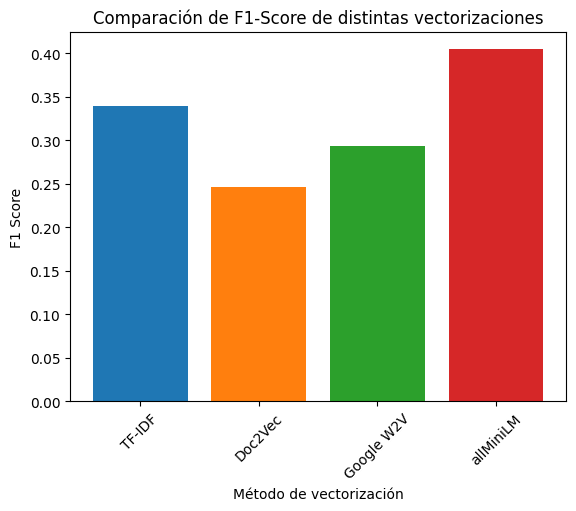

In [19]:
import matplotlib.pyplot as plt

# Graficamos los resultados
for f1, label in evaluaciones:
    # Asigna colores en función del f1_score
    #colores = plt.cm.viridis(np.array(y) / max(y))

    # Crea el gráfico de barras horizontales
    #plt.bar(x, y, color=colores)
    plt.bar(label, f1)


# Personaliza el gráfico
plt.ylabel('F1 Score')
plt.xlabel('Método de vectorización')
plt.title('Comparación de F1-Score de distintas vectorizaciones')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad

# Muestra el gráfico
plt.show()

In [ ]:
# Comparar los resultados de TF-IDF con el dataset extendido
ext_data = pd.ExcelFile(extended_file, sheet_name="data")
ext_data = mapeo_de_labels(ext_data, 'gs_text34') # Añade la columna 'Clases'
X = datos['open_response']
#y = datos['Clases']
y = datos['gs_text34']

# Guardar datos